In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal as mnorm
from scipy.stats import kde
from tqdm import tqdm_notebook
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

## синтезирую задачу

In [2]:
x_class1 = np.random.randn(5000, 2)*np.array([2, 3])+np.array([3, 3])

In [3]:
x_class0 = np.random.randn(1000, 2)*np.array([3, 2])-np.array([0, 0])

In [4]:
y = np.squeeze(np.concatenate([np.ones((5000,1), dtype=int), np.zeros((1000,1), dtype=int)], axis=0))

In [5]:
x = np.concatenate([x_class1, x_class0], axis=0)
x.shape

(6000, 2)

In [6]:
y.shape

(6000,)

In [7]:
nbins=300

In [8]:
xmesh, ymesh = np.mgrid[-10:10:nbins*1j, -10:10:nbins*1j]

In [9]:
k_class0 = kde.gaussian_kde(x_class0.T)
dens_class0 = k_class0(np.vstack([xmesh.flatten(), ymesh.flatten()]))

In [10]:
k_class1 = kde.gaussian_kde(x_class1.T)
dens_class1 = k_class1(np.vstack([xmesh.flatten(), ymesh.flatten()]))

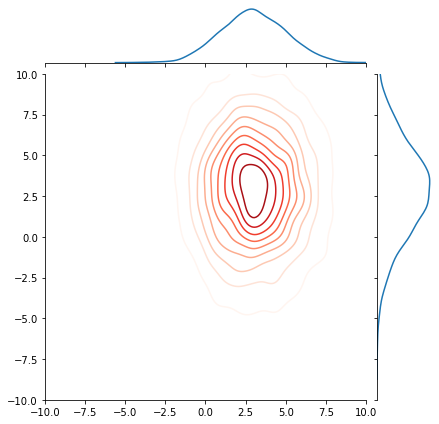

In [11]:
p = sns.jointplot(x=x_class1[:,0], y=x_class1[:,1], kind='kde', cmap='Reds')
_ = p.ax_marg_x.set_xlim(-10, 10)
_ = p.ax_marg_y.set_ylim(-10, 10)

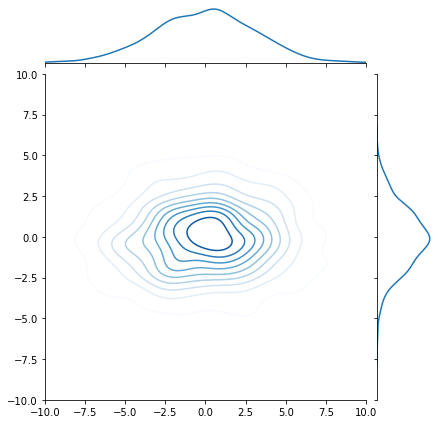

In [12]:
p = sns.jointplot(x=x_class0[:,0], y=x_class0[:,1], kind='kde', cmap='Blues')
_ = p.ax_marg_x.set_xlim(-10, 10)
_ = p.ax_marg_y.set_ylim(-10, 10)

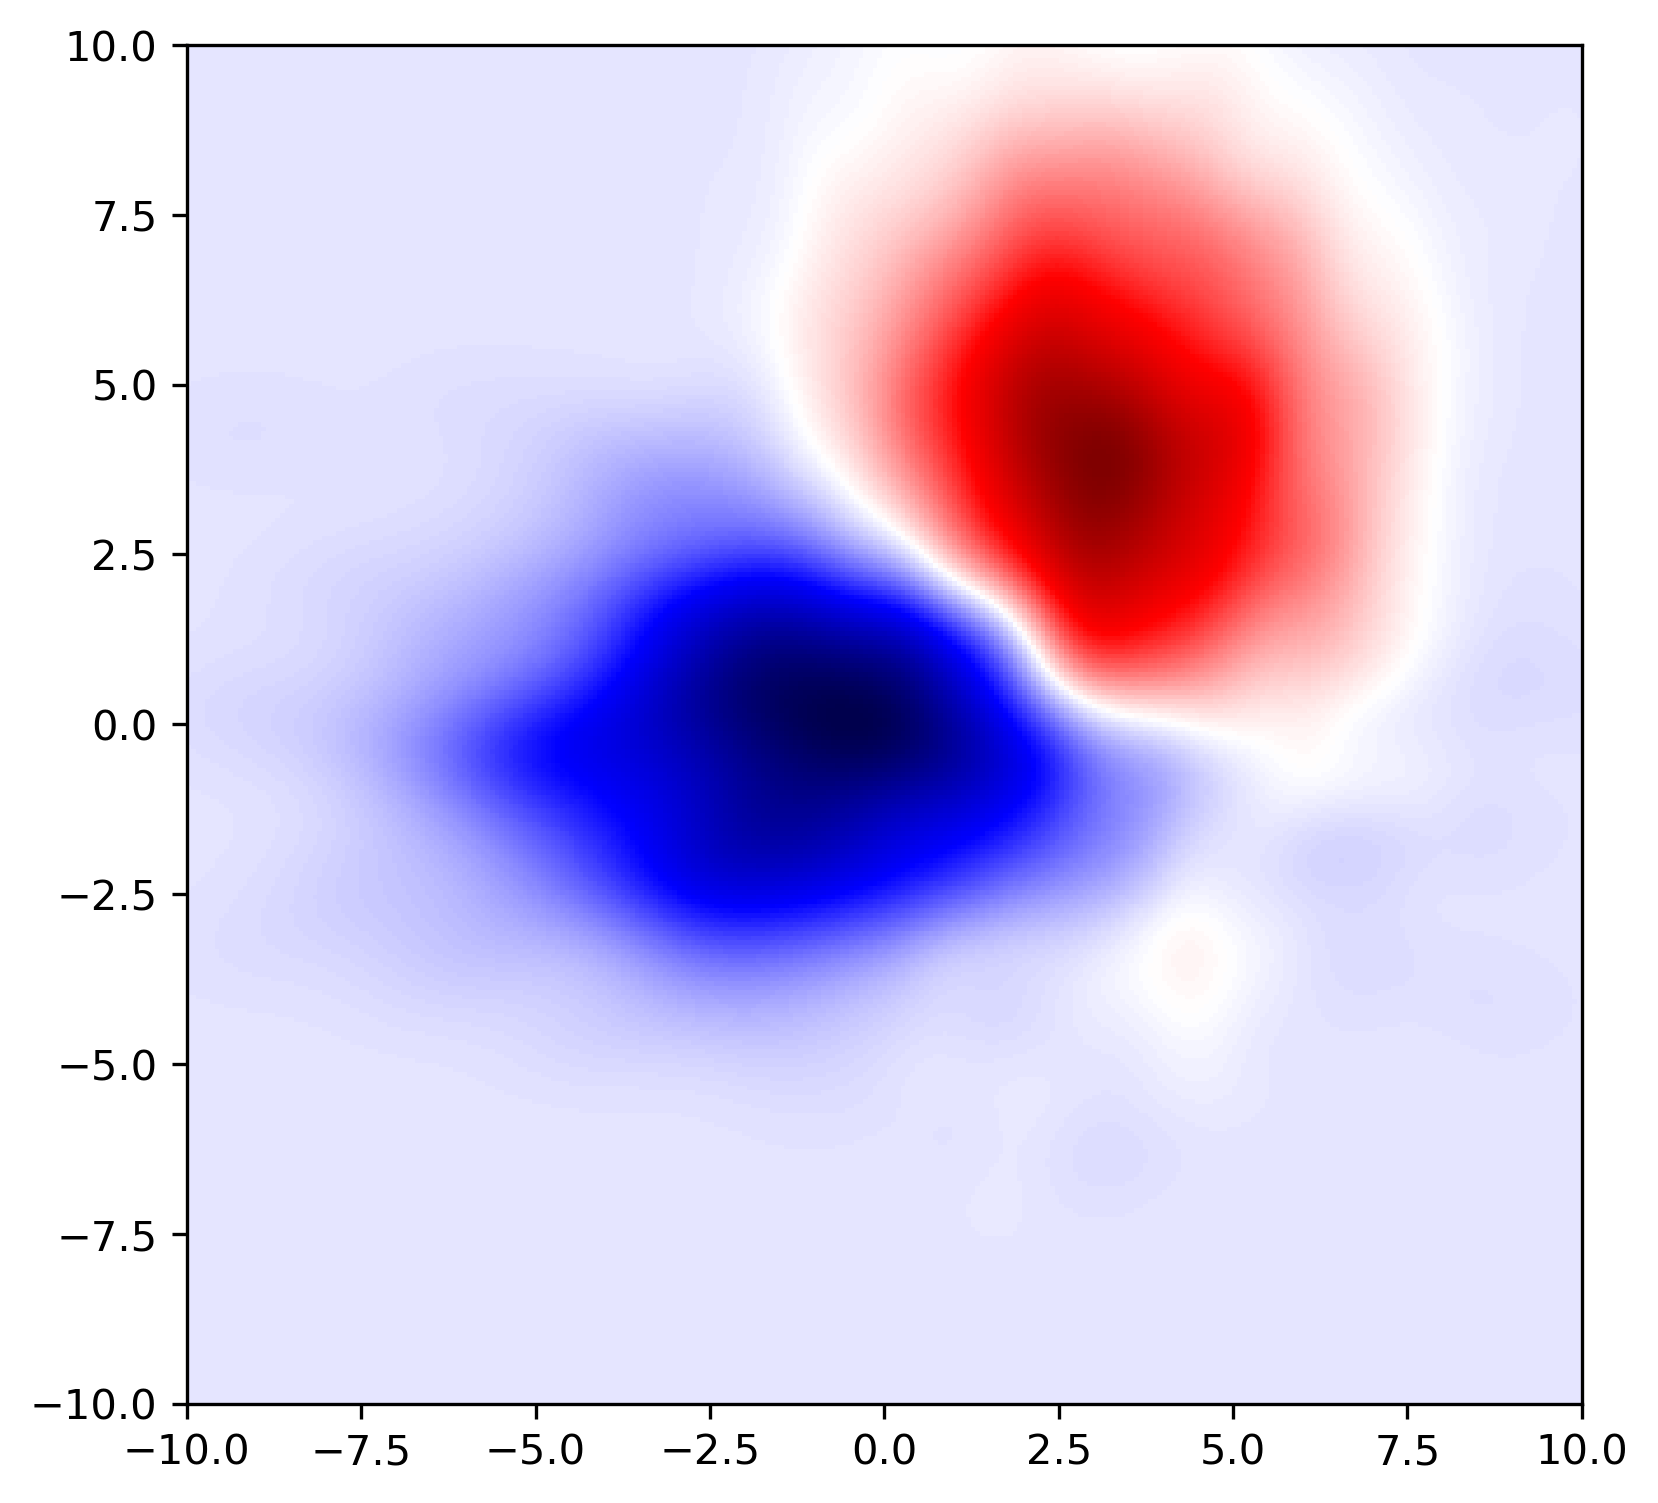

In [13]:
_ = plt.figure(figsize=(6,6), dpi=300)

_ = plt.pcolormesh(xmesh, ymesh, (dens_class1-dens_class0).reshape(xmesh.shape), cmap='seismic')

_ = plt.xlim(-10, 10)
_ = plt.ylim(-10, 10)

In [15]:
class LogRegression:
    def __init__(self):
        self.theta = None
    
    def compute_probabilities(self, X_matrix, theta):
        p = 1/(1+np.exp(-np.dot(X_matrix, theta[:,np.newaxis])))
        return p
    
    def loss(self, X_matrix, y, curr_theta):
        p = self.compute_probabilities(X_matrix, curr_theta)
        y_true = y[:,np.newaxis]
        l = -y_true*np.log(p) - (1-y_true)*np.log(1-p)
        return float(np.squeeze(l.mean(axis=0, keepdims=True)))
    
    def loss_grad(self, X_matrix, y, curr_theta):
        p = self.compute_probabilities(X_matrix, curr_theta)
        y_true = y[:,np.newaxis]
        grad = -(y_true-p)*X_matrix
        return grad.mean(axis=0, keepdims=True).T
    
    
    def fit(self, X, y, epsilon=1e-4, etha=1e-3):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert (y.ndim == 1), "y should be 1-dimensional"
        
        X_0 = np.ones((X.shape[0], 1), dtype=np.float)
        X_matrix = np.concatenate([X_0, X], axis=1)
        theta_start = np.random.randn(X_matrix.shape[1], 1)
        loss_history = []
        optimization_result = minimize(lambda t: self.loss(X_matrix, y, t),
                                       theta_start,
                                       jac = lambda t: np.squeeze(self.loss_grad(X_matrix, y, t)),
                                       callback = lambda xk: loss_history.append(self.loss(X_matrix, y, xk)))
        
        self.theta = optimization_result.x
        return loss_history
    
    def predict(self, X, return_proba = False):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert (self.theta is not None), "parameters are None. perhaps, you should fit the model first."
        
        X_0 = np.ones((X.shape[0], 1), dtype=np.float)
        X_matrix = np.concatenate([X_0, X], axis=1)
        p = self.compute_probabilities(X_matrix, self.theta)
        y_pred = (p>=0.5).astype(int)
        
        if return_proba:
            return y_pred, p
        else:
            return y_pred

In [16]:
sample_size = x.shape[0]
Xtrain,Xtest,ytrain,ytest = train_test_split(x,y, test_size=0.2)
LR = LogRegression()
LR.fit(Xtrain, ytrain)
ytest_pred,ytest_proba = LR.predict(Xtest, return_proba=True)
print('accuracy: ' + str(np.mean(np.squeeze(ytest_pred)==ytest)))

accuracy: 0.8816666666666667


$$
TPR = \frac{TP}{TP+FN} = Recall
$$

In [17]:
def tpr(labels_true, pred_proba, proba_threshold):
    pred_ones = np.squeeze(pred_proba >= proba_threshold)
    TP = pred_ones & (labels_true == 1)
    tprate = np.sum(TP)/np.sum(labels_true == 1)
    return tprate

$$
FPR = \frac{FP}{FP+TN}
$$

In [18]:
def fpr(labels_true, pred_proba, proba_threshold):
    pred_ones = np.squeeze(pred_proba >= proba_threshold)
    FP = pred_ones & (labels_true == 0)
    fprate = np.sum(FP)/np.sum(labels_true == 0)
    return fprate

In [19]:
tprs = []
fprs = []
threholds = np.linspace(0.0, 1.0, 100)[::-1]
for th in threholds:
    tprs.append(tpr(ytest, ytest_proba, th))
    fprs.append(fpr(ytest, ytest_proba, th))

Text(0, 0.5, 'TPR')

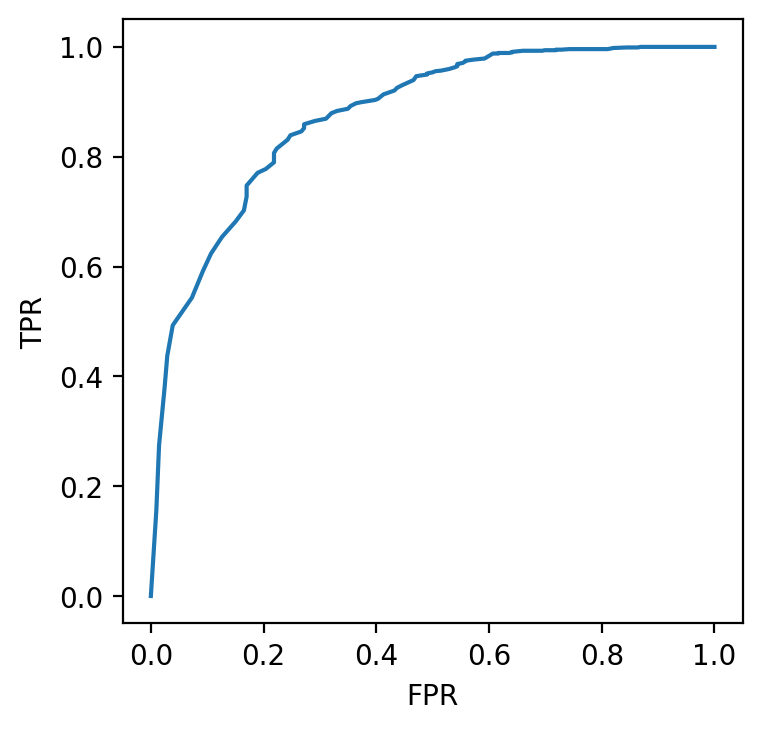

In [20]:
f = plt.figure(figsize=(4,4), dpi=200)
plt.plot(fprs, tprs)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [21]:
tprs = np.array(tprs)
fprs = np.array(fprs)

In [22]:
fprs[0], tprs[0]

(0.0, 0.0)

In [23]:
aucroc = np.sum(0.5*(tprs[1:]+tprs[:-1]) * (fprs[1:]-fprs[:-1]))

In [33]:
aucroc

0.8664692873677248

In [24]:
np.trapz(tprs, fprs)

0.8746654685393916

Text(0, 0.5, 'TPR')

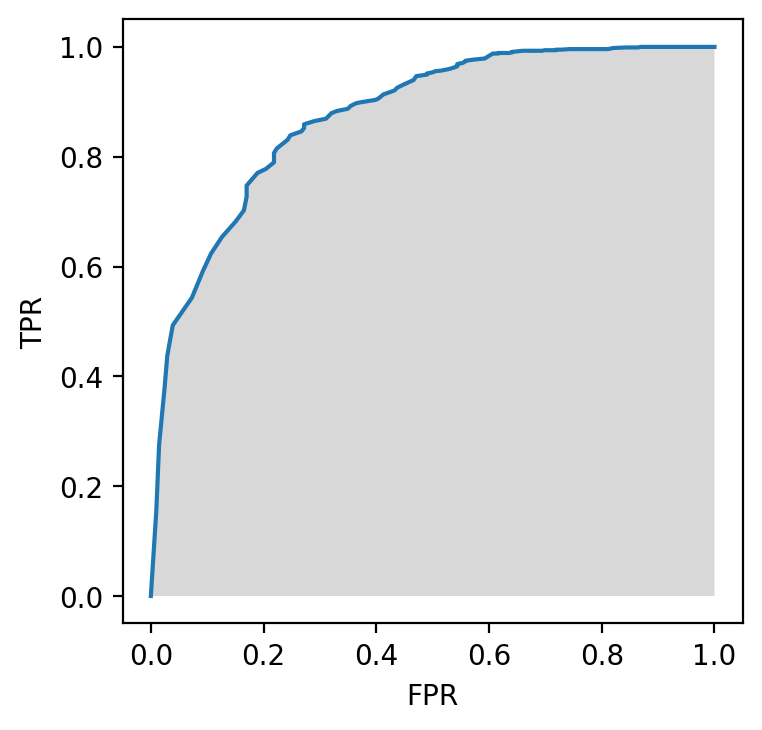

In [25]:
f = plt.figure(figsize=(4,4), dpi=200)
plt.plot(fprs, tprs)
plt.fill_between(fprs, tprs, 0.0, facecolor='gray', alpha=0.3)
plt.xlabel('FPR')
plt.ylabel('TPR')